In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.utils import MixtureNormalSampler
import ott
import matplotlib.pyplot as plt
import numpy as np
import optax
import jax
import jax.numpy as jnp
import scanpy as sc

from entot.models.gen_model import OTFlowMatching, MLP_FM, MLP_FM2, OriginalFlowMatching, MLP_no_noise

2023-07-11 13:02:34.146040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
adata = sc.read("../../../../data/adata_pancreas_2019_processed_new.h5ad")

In [5]:
sc.pp.pca(adata, n_comps=10)

In [6]:
source = adata[adata.obs["day"]=="14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["day"]=="15.5"].obsm["X_pca"].copy()


In [7]:
neural_net = MLP_no_noise(10, [64, 64, 64, 64])
otfm = OriginalFlowMatching(neural_net, 10, 1000)

In [8]:
otfm(source, target, 800, 800)

2023-07-11 13:02:48.619019: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
100%|██████████| 1000/1000 [00:32<00:00, 30.57it/s]


In [9]:
#plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

In [11]:
#plt.plot(np.arange(len(otfm.metrics["loss"][800:])), otfm.metrics["loss"][800:])

In [13]:
pushed,_ = otfm.transport(source)

In [14]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed[0,...], target), axis=0)

In [15]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-pac

In [16]:
sc.tl.umap(bdata)

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


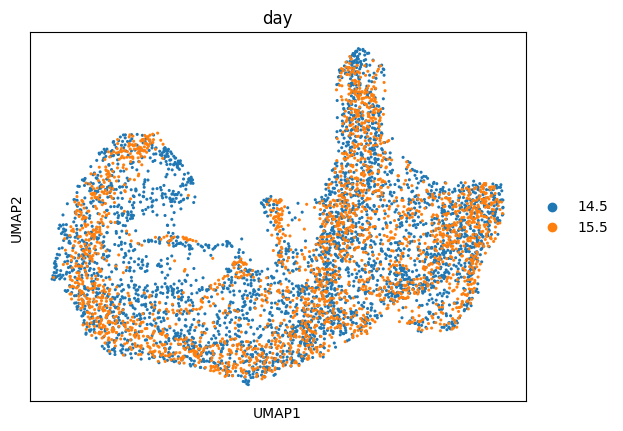

In [17]:
sc.pl.umap(bdata, color="day")

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


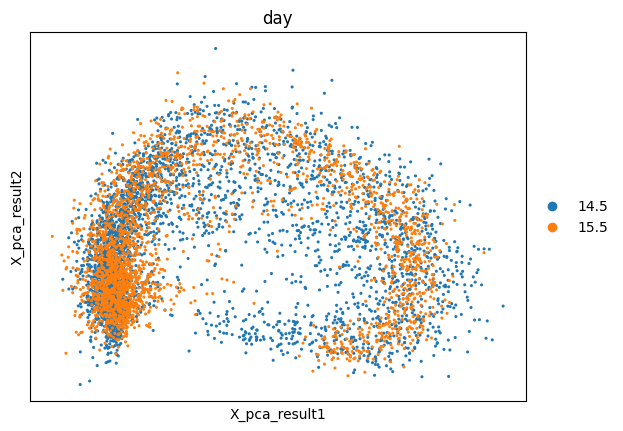

In [18]:
sc.pl.embedding(bdata, basis="X_pca_result", color="day")

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


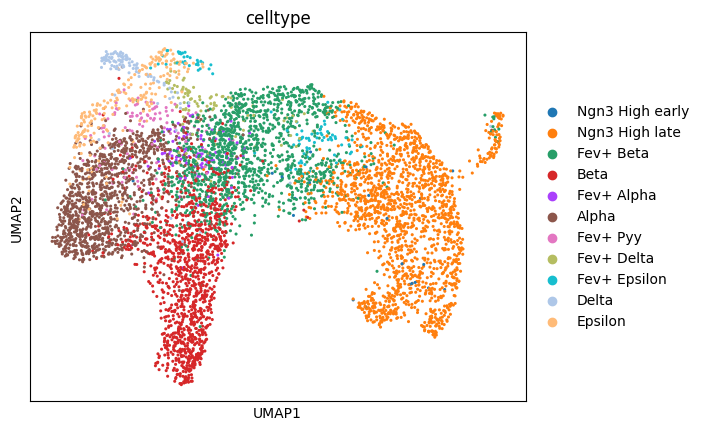

In [17]:
sc.pl.umap(bdata, color="celltype")

In [52]:
adata.obsm["X_pca_original"] = np.concatenate((source, target), axis=0)


In [53]:
sc.pp.neighbors(adata, use_rep="X_pca_original")

In [54]:
sc.tl.umap(adata)

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


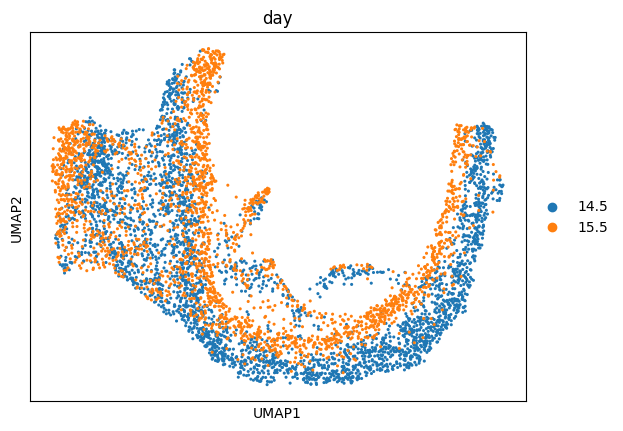

In [55]:
sc.pl.umap(adata, color="day")

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


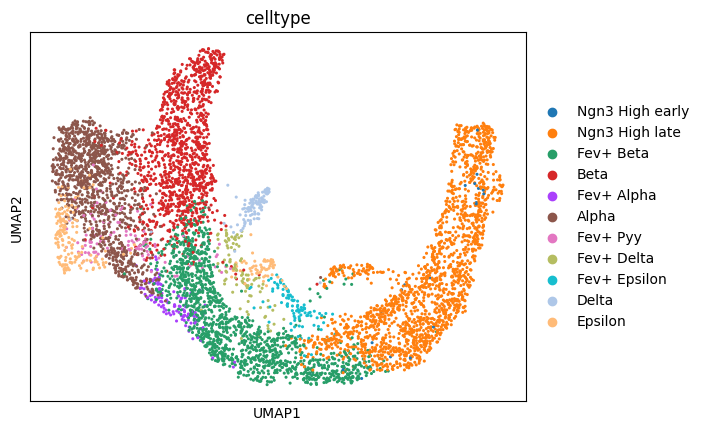

In [56]:
sc.pl.umap(adata, color="celltype")

In [57]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source, seed=i)[0][0,...]


In [58]:
samples = jnp.array(res)

In [59]:
samples.shape

(15, 3575, 10)

In [60]:
vars = jnp.var(samples, axis=0)

In [61]:
vars_summed = jnp.sum(vars, axis=1)

In [62]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
bdata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

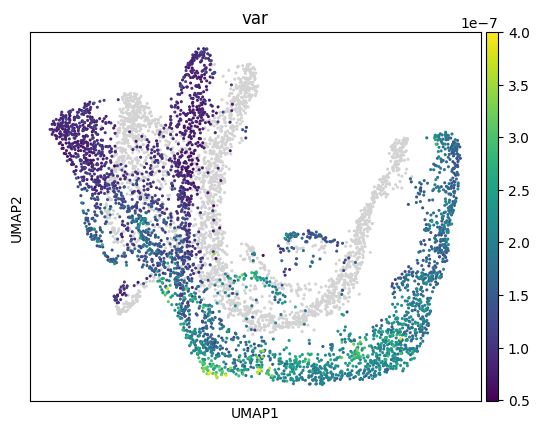

In [63]:
sc.pl.umap(bdata, color="var")

In [64]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Ngn3 High early,1.884327e-07
Ngn3 High late,1.868475e-07
Fev+ Beta,1.864223e-07
Beta,8.797143e-08
Fev+ Alpha,1.878583e-07
Alpha,1.040547e-07
Fev+ Pyy,1.318387e-07
Fev+ Delta,1.612975e-07
Fev+ Epsilon,2.199629e-07


In [35]:
cdata = bdata[~bdata.obs["celltype"].isin(["Acinar", "Ductal", "Tip", "Trunk", "Multipotent", "Ngn3 low EP"])].copy()

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


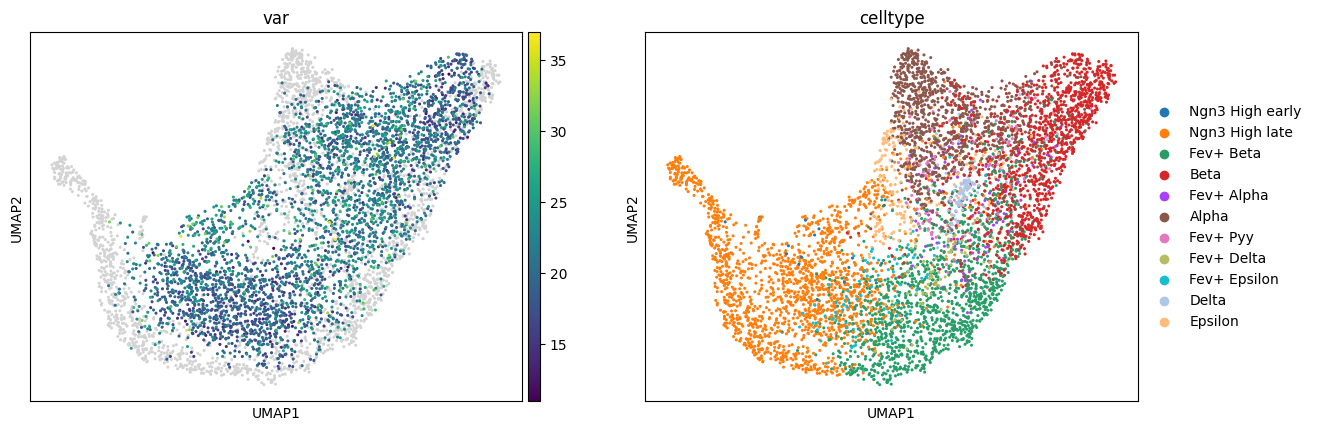

In [36]:
sc.pl.umap(cdata, color=["var", "celltype"])